In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import gym.spaces as spaces
from dm_control import suite
from dm_control.suite.wrappers import pixels

seed = 0
domain = "walker"
task = "run"
img_size = 64

env = suite.load(
    domain,
    task,
    task_kwargs=dict(random=seed),
    environment_kwargs=dict(flat_observation=True),
)

# get state and observation space for expert from joints
control_min = env.action_spec().minimum[0]
control_max = env.action_spec().maximum[0]
control_shape = env.action_spec().shape
action_space = spaces.Box(control_min, control_max, control_shape)
total_size = 0
for i, j in env.observation_spec().items():
    total_size += j.shape[0] if len(j.shape) > 0 else 1
observation_space = spaces.Box(-np.inf, np.inf, (total_size,))

# zoom in camera for quadruped
camera_id = dict(locom_rodent=1, quadruped=2).get(domain, 0)
render_kwargs = dict(height=img_size, width=img_size, camera_id=camera_id)
env = pixels.Wrapper(env, pixels_only=False, render_kwargs=render_kwargs)
env._size = (img_size, img_size)
env._camera = camera_id

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from skrl.models.torch import DeterministicMixin, Model


# define models (deterministic models) using mixin
class Actor(DeterministicMixin, Model):
    def __init__(self, observation_space, action_space, device, clip_actions=False):
        Model.__init__(self, observation_space, action_space, device)
        DeterministicMixin.__init__(self, clip_actions)

        self.linear_layer_1 = nn.Linear(self.num_observations, 400)
        self.linear_layer_2 = nn.Linear(400, 300)
        self.action_layer = nn.Linear(300, self.num_actions)

    def compute(self, inputs, role):
        x = F.relu(self.linear_layer_1(inputs["states"]))
        x = F.relu(self.linear_layer_2(x))
        return torch.tanh(self.action_layer(x)), {}


class Critic(DeterministicMixin, Model):
    def __init__(self, observation_space, action_space, device, clip_actions=False):
        Model.__init__(self, observation_space, action_space, device)
        DeterministicMixin.__init__(self, clip_actions)

        self.linear_layer_1 = nn.Linear(self.num_observations + self.num_actions, 400)
        self.linear_layer_2 = nn.Linear(400, 300)
        self.linear_layer_3 = nn.Linear(300, 1)

    def compute(self, inputs, role):
        x = F.relu(self.linear_layer_1(torch.cat([inputs["states"], inputs["taken_actions"]], dim=1)))
        x = F.relu(self.linear_layer_2(x))
        return self.linear_layer_3(x), {}

In [4]:
device = "cpu"
models = {}
models["policy"] = Actor(observation_space, action_space, device)
models["target_policy"] = Actor(observation_space, action_space, device)
models["critic_1"] = Critic(observation_space, action_space, device)
models["critic_2"] = Critic(observation_space, action_space, device)
models["target_critic_1"] = Critic(observation_space, action_space, device)
models["target_critic_2"] = Critic(observation_space, action_space, device)

In [5]:
from skrl.agents.torch.td3 import TD3, TD3_DEFAULT_CONFIG

cfg = TD3_DEFAULT_CONFIG.copy()
cfg["exploration"]["noise"] = None
cfg["random_timesteps"] = 0
cfg["learning_starts"] = 1000000

expert = TD3(
    models=models,
    memory=None,
    cfg=cfg,
    observation_space=observation_space,
    action_space=action_space,
    device=device,
)

expert.load("agent_400000.pt")

[skrl:WARNING] agents:TD3: No smooth regularization noise specified to reduce variance during training
/home/tverbele/Code/python/hackaton/.venv/lib/python3.11/site-packages/skrl/agents/torch/base.py:383: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please o

100%|██████████| 256/256 [00:02<00:00, 122.64it/s]


expert_rollout

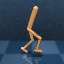

In [6]:
import mediapy
from tqdm import tqdm

timesteps = 256

expert_imgs = []
actions = []

ts, reward, discount, obs = env.reset()
expert_imgs.append(obs["pixels"])
for timestep in tqdm(range(timesteps)):
    with torch.no_grad():
        action,_,_ = expert.act(torch.from_numpy(obs["observations"]).float().unsqueeze(0), timestep, timesteps)
        action = action.cpu().numpy().squeeze()
        actions.append(action)
        ts, reward, discount, obs = env.step(action)
        if timestep != timesteps - 1:
            expert_imgs.append(obs["pixels"])

with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"expert_rollout": expert_imgs}, width=320, height=320, fps=20, codec="gif")

(128, 64, 64, 3)
(128, 6)


expert

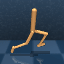

In [7]:
import jax.numpy as jnp

observations = jnp.stack(expert_imgs)[128:]
actions = jnp.stack(actions)[128:]
print(observations.shape)
print(actions.shape)

with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"expert": [i for i in observations]}, width=320, height=320, fps=20, codec="gif")

In [8]:
from rgm import *

In [9]:
rgm = RGM()
rgm.fit(observations, actions)

Maximum probability state about factor 0 at time 0: 50
Maximum probability state about factor 0 at time 1: 28
Maximum probability state about factor 0 at time 2: 27
Maximum probability state about factor 0 at time 3: 24
Maximum probability state about factor 0 at time 4: 23
Maximum probability state about factor 0 at time 5: 12
Maximum probability state about factor 0 at time 6: 37
Maximum probability state about factor 0 at time 7: 41
Maximum probability state about factor 0 at time 8: 26
Maximum probability state about factor 0 at time 9: 57
Maximum probability state about factor 0 at time 10: 40
Maximum probability state about factor 0 at time 11: 63
Maximum probability state about factor 0 at time 12: 19
Maximum probability state about factor 0 at time 13: 13
Maximum probability state about factor 0 at time 14: 4
Maximum probability state about factor 0 at time 15: 1
Maximum probability state about factor 0 at time 16: 8
Maximum probability state about factor 0 at time 17: 60
Maxim

In [10]:
rgm.save("expert.npz")

In [11]:
qs = rgm.infer_states(observations[:4], actions[:4], None)
print(qs)

[Array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float32)]


In [12]:
qs = rgm.infer_states(observations[:4], None, None)
print(qs)

[Array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float32)]


In [13]:
imgs, u = rgm.reconstruct(qs)
print(u)
print(actions[:4])
print(u - actions[:4])

[[-1.  1. -1. -1. -1.  1.]
 [-1. -1. -1. -1. -1.  1.]
 [-1.  1. -1. -1.  1.  1.]
 [-1. -1. -1. -1.  1.  1.]]
[[-1.  1. -1. -1. -1.  1.]
 [-1. -1. -1. -1. -1.  1.]
 [-1.  1. -1. -1.  1.  1.]
 [-1. -1. -1. -1.  1.  1.]]
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


input,reconstruction

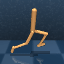
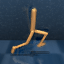

In [14]:
import mediapy

with mediapy.set_show_save_dir("."):
    mediapy.show_videos(
        {"input": [observations[i] for i in range(4)], "reconstruction": [im for im in imgs]}, width=320, height=320, fps=2, codec="gif"
    )

In [15]:
priors = rgm.infer_empirical_prior(jnp.array([[0]]), qs)

In [16]:
priors[-1]

Array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]],      dtype=float32)

[[-1.    1.   -1.   -1.    1.    1.  ]
 [-1.    0.25 -1.   -1.    1.   -1.  ]
 [-1.    1.   -1.    1.   -1.   -1.  ]
 [-1.   -1.   -1.    1.   -1.   -1.  ]]
[[-1.          1.         -1.         -1.          1.          1.        ]
 [-1.          0.17137432 -1.         -1.          1.         -1.        ]
 [-1.          1.         -1.          1.         -1.         -1.        ]
 [-1.         -1.         -1.          1.         -1.         -1.        ]]
[[0.         0.         0.         0.         0.         0.        ]
 [0.         0.07862568 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]]


input_next,prediction

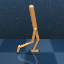
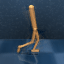

In [17]:
imgs, u = rgm.reconstruct([priors[-1][0]])
print(u)
print(actions[4:8])
print(u - actions[4:8])
with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"input_next": [observations[i] for i in range(4,8)], "prediction": [im for im in imgs]}, width=320, height=320, fps=2, codec="gif")

In [18]:
qs_next = rgm.infer_states(observations[4:8], None, priors)

In [19]:
print(qs_next)

[Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],      dtype=float32)]


[[-1.    1.   -1.   -1.    1.    1.  ]
 [-1.    0.25 -1.   -1.    1.   -1.  ]
 [-1.    1.   -1.    1.   -1.   -1.  ]
 [-1.   -1.   -1.    1.   -1.   -1.  ]]


next

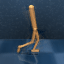

In [20]:
imgs, u = rgm.reconstruct(qs_next)
print(u)
with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"next": [im for im in imgs]}, width=320, height=320, fps=2, codec="gif")

imagination

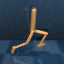

In [21]:
o, p = predict(rgm.agents, qs, jnp.array([[0]]), num_steps=10)
imgs, u = rgm.discrete_2_rgb_action(o[0])

with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"imagination": [im for im in imgs]}, width=320, height=320, fps=20, codec="gif")

masked,unmasked

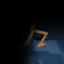
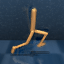

In [22]:
mask_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13]

one_hot_masked = rgm.to_one_hot(observations[:4], actions[:4], mask_indices=mask_indices)
mims, u = rgm.discrete_2_rgb_action(one_hot_masked)

qs = rgm.infer_states(one_hot_masked, one_hot_obs=True)
ims, u = rgm.reconstruct(qs)

with mediapy.set_show_save_dir("."):
    mediapy.show_videos(
        {"masked": [mims[i] for i in range(4)], "unmasked": [ims[i] for i in range(4)]},
        width=320,
        height=320,
        fps=2,
        codec="gif",
    )

100%|██████████| 100/100 [02:03<00:00,  1.23s/it]


control_init,imagined_init

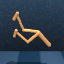
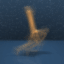

In [23]:
import mediapy
from tqdm import tqdm

imgs = []
recs = []

rgm = RGM()
rgm.load("expert.npz")
rgm_agent = RGMAgent(rgm)

timesteps = 100

ts, reward, discount, obs = env.reset()
imgs.append(obs["pixels"])
for i in tqdm(range(timesteps)):
    action, im = rgm_agent.act(obs)
    ts, reward, discount, obs = env.step(action)
    imgs.append(obs["pixels"])
    recs.append(im)

with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"control_init": imgs, "imagined_init": recs}, width=320, height=320, fps=20, codec="gif")

100%|██████████| 300/300 [06:44<00:00,  1.35s/it]


control,imagined

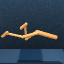
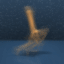

In [25]:
import mediapy
from tqdm import tqdm

imgs = []
recs = []

rgm = RGM()
rgm.load("expert.npz")
rgm_agent = RGMAgent(rgm)

timesteps = 300

ts, reward, discount, obs = env.reset()
imgs.append(obs["pixels"])
for i in tqdm(range(timesteps)):
    action, im = rgm_agent.act(obs)
    #print(rgm_agent.posterior)    

    # TODO use expert to get to sensible init state?
    expert_action = None
    with torch.no_grad():
        a, _, _ = expert.act(torch.from_numpy(obs["observations"]).float().unsqueeze(0), timestep, timesteps)
        expert_action = a.cpu().numpy().squeeze()

    #print(action, expert_action)
    use_expert = i < timesteps / 2
    action_select = expert_action if use_expert else action

    ts, reward, discount, obs = env.step(action_select)
    pixels = obs["pixels"]
    # draw border when using expert policy
    if use_expert:
        pixels[:, :2, :] = 0
        pixels[:, -2:, :] = 0
        pixels[:2, :, :] = 0
        pixels[-2:, :, :] = 0
        pixels[:, :2, 0] = 255
        pixels[:, -2:, 0] = 255
        pixels[:2, :, 0] = 255
        pixels[-2:, :, 0] = 255
   
    imgs.append(pixels)
    recs.append(im)

with mediapy.set_show_save_dir("."):
    mediapy.show_videos({"control": imgs, "imagined": recs}, width=320, height=320, fps=20, codec="gif")

In [28]:
rgm.agents[-1].B[0].shape

(1, 32, 32, 1)